# Initial exploration of existing data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd

In [3]:
#Current working directory
#Path().resolve()

input_path = '.\data'

In [4]:
from model.parameters import stations_montrouge, stations_paris, relevant_stations
from model.parameters import week_ends, week_days

## Format of existing data

In [5]:
#example_file = Path(input_path, "Summary_2022-12-14.parquet")
#example_df = pd.read_parquet(example_file)
#example_df

## Total number of docking points available

NB: 
* docks = docking points = bornettes en français dans le texte !
* to generate current station status, the easiest way is to run `fetch_save_stations_info` directly from Python (as opposed to from a Notebook).

### Initial inquiry

In [6]:
input_file = Path(input_path, "station_info_2022-12-21.csv")
station_df = pd.read_csv(input_file)

In [7]:
len(station_df)

1449

In [8]:
station_df[station_df["stationCode"].astype("string").isin(relevant_stations)]

,stationCode,station_name,capacity,station_geo,credit_card
716,2006,Place des Victoires,24,"48.86604,2.34203",False
717,2008,Mairie du 2ème,28,"48.86722,2.34046",False
718,2009,Filles Saint-Thomas - Place de la Bourse,58,"48.86890,2.33975",False
796,2111,Chabanais - Petits Champs,30,"48.86704,2.33672",False
804,2112,Bibliothèque Nationale - Richelieu,17,"48.86829,2.33809",False
808,21205,Arthur Auger - Jean Jaurès,26,"48.81374,2.30693",False
810,21209,Molière - République,30,"48.81112,2.31457",False
811,21212,Marne - Germain Dardan,22,"48.81154,2.30307",True
813,21215,Verdier - Jean Jaurès,33,"48.81614,2.31236",True


### Station info overview

In [9]:
station_infos = sorted(Path(input_path).glob('station_info*.csv'))
#station_infos

In [10]:
def process_station_info(file_path):
    """ Process data and return suitable dataframe """
    current_df = pd.read_csv(file_path)
    current_date = file_path.name[13:-4]
    current_df["date"]=current_date
    
    return current_df

In [11]:
#station_infos[5:] keep only input with headers
output_df = pd.concat([process_station_info(file_path) for file_path in station_infos[5:]], ignore_index=True)

In [12]:
# NB: conversion to be really sure (the very last data point includes numbers instead of string)
output_df["stationCode"] = output_df["stationCode"].astype("string")

In [13]:
#output_df.to_csv("overview_station_info.csv")
len(output_df)

216070

### Display capacity evolution

Below, we generate a table of "capacity" *per* day and *per* station. We want to check whether these capacities remain constant with time! 

In [14]:
reduced_df = output_df[output_df["stationCode"].isin(relevant_stations)].reset_index()[["stationCode", "capacity", "date"]]
evol_data = reduced_df.pivot(index="date", columns=["stationCode"])
evol_data

capacity                                                
stationCode    2006  2008  2009  2111  2112  21205 21209 21212 21215
date                                                                
2022-05-20        24    28    58    30    17    26    30    22    33
2022-05-21        24    28    58    30    17    26    30    22    33
2022-05-22        24    28    58    30    17    26    30    22    33
2022-05-23        24    28    58    30    17    26    30    22    33
2022-05-24        24    28    58    30    17    26    30    22    33
...              ...   ...   ...   ...   ...   ...   ...   ...   ...
2022-10-12        24    28    58    30    17    26    30    22    33
2022-10-13        24    28    58    30    17    26    30    22    33
2022-10-14        24    28    58    30    17    26    30    22    33
2022-10-15        24    28    58    30    17    26    30    22    33
2022-12-21        24    28    58    30    17    26    30    22    33

[150 rows x 9 columns]

In [15]:
for stationCode in relevant_stations:
    print("Unique values for station {}:".format(stationCode))
    print(evol_data[("capacity", stationCode)].unique())

Unique values for station 21209:
[30]
Unique values for station 21205:
[26]
Unique values for station 21212:
[22]
Unique values for station 21215:
[33]
Unique values for station 2006:
[24]
Unique values for station 2009:
[58]
Unique values for station 2112:
[17]
Unique values for station 2008:
[28]
Unique values for station 2111:
[30]


The previous loop shows that for the 9 stations under consideration, `'capacity'` is constant over the observation period.

NB: to be absolutely exact, 
* we did not record these values after 2022-10-15, except for a one-off recording on 2022-12-21;
* we did not use records before 2022-05-20.

Based on the data we have, it would be possible to investigation which stations saw there 'capacity' evolve over the observation period.

#### Special case of 22202 and its variable capacity

Let us investigate the case of 22202 and its capacity of 30 and 0!

In [17]:
#(evol_data[('capacity', '22202')] == 0).sum()

There is only one data point where '22202' has capacity 0, and since on 2022-12-21 it had capacity 0, we can safely assume that its "real" capacity is 30.

### Number of docking points available - summary

Taking the (reasonable) assumption that the capacities of our 4 stations of interest were constant over the observation period, we can summarize their capacities in the series below: 

In [18]:
from model.parameters import capacity_series

## Access parquet files - daily summaries

From the "last modified" dates, it appears that the data is "regular" (*i.e.* without manual manipulations) from 2022-05-20 onwards!

As a first iteration, it seems acceptable to start with this data only! (rows noted `parquet_files[20:]` as of 2022-12-21)

### Compile daily summaries

In [19]:
parquet_files = list(Path(input_path).glob('*.parquet'))
#parquet_files[:5]

In [20]:
parquet_files[20]

WindowsPath('data/Summary_2022-05-20.parquet')

In [21]:
def process_daily_summaries(file_path, current_stations=stations_paris):
    """ Process data and return suitable dataframe """
    current_df = pd.read_parquet(file_path, columns=["file_time", "stationCode", "available_mechanical", "available_electrical"])
    current_df["stationCode"] = current_df["stationCode"].astype("string")
    
    # Keep only stations of interest
    current_df = current_df[current_df["stationCode"].isin(current_stations)]
    
    return current_df

In [22]:
summary_df = pd.concat(process_daily_summaries(file_path, relevant_stations) for file_path in parquet_files[20:])
summary_df

,stationCode,available_mechanical,available_electrical
file_time,,,
2022-05-20 00:00:08+02:00,2112,0.0,1.0
2022-05-20 00:00:08+02:00,21205,3.0,9.0
2022-05-20 00:00:08+02:00,2008,1.0,0.0
2022-05-20 00:00:08+02:00,2009,4.0,0.0
2022-05-20 00:00:08+02:00,21215,15.0,1.0
...,...,...,...
2022-12-18 23:50:08+01:00,2008,5.0,0.0
2022-12-18 23:50:08+01:00,2009,1.0,3.0
2022-12-18 23:50:08+01:00,21209,0.0,1.0


### Preprocessing - capacities and time variables

In [23]:
# Merge with capacities
aux = summary_df.merge(capacity_series, left_on="stationCode", right_index=True)

#aux.groupby(["stationCode"])["capacity"].unique()

In [24]:
aux["free_docks"] = aux["capacity"] - aux["available_mechanical"] - aux["available_electrical"]

In [25]:
# Sanity check: always positive?
aux["free_docks"].min()

0.0

In [26]:
aux["free_docks_ratio"] = aux["free_docks"]/aux["capacity"]

In [27]:
aux["free_docks_ratio"].max()

1.0

In [28]:
aux["free_docks_ratio"].min()

0.0

In [29]:
aux["local_hour"] = aux.index.hour

In [30]:
aux["local_minute"] = aux.index.minute

In [31]:
aux["week_day"] = aux.index.weekday

### Statistics on period of interest

As an initial investigation, we could simply keep (and display) statistics for the period of interest.

In [32]:
def compute_hist(stationCode, local_hour, local_minute, week_day=None):
    """ Display histogram of 'free_docks' for specified station and local time
    
    Args:
        * stationCode should be provided as a string.
        * week_day should be a list of integers (0=Monday, 6=Sunday)
    """
    mask = (aux["stationCode"]==stationCode)&(aux["local_hour"]==local_hour)&(aux["local_minute"]==local_minute)
    
    if week_day:
        mask = mask & (aux["week_day"].isin(week_day))
    
    return aux[mask]["free_docks"].value_counts().sort_index().reindex(range(0, capacity_series.loc[stationCode]+1), fill_value=0)

In [33]:
def display_hist_ratio(stationCode, local_hour, local_minute, week_day=None, bins=20):
    """ Display histogram of 'free_docks' for specified station and local time
    
    Args:
        * stationCode should be provided as a string.
        * week_day should be a list of integers (0=Monday, 6=Sunday)
    """
    mask = (aux["stationCode"]==stationCode)&(aux["local_hour"]==local_hour)&(aux["local_minute"]==local_minute)
    
    if week_day:
        mask = mask & (aux["week_day"].isin(week_day))
    
    return aux[mask]["free_docks_ratio"].plot.hist(bins=bins, xlim=[0,1])

#### Graphs for 2112 (BNF station)

<AxesSubplot:ylabel='Frequency'>

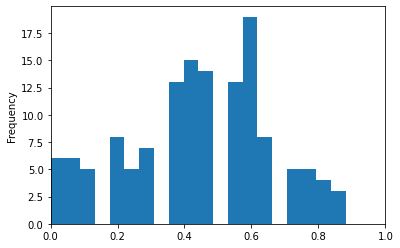

In [34]:
display_hist_ratio("2112", 9, 20, week_days, bins=20)

In [35]:
compute_hist("2112", 9, 20)

0      6
1      6
2      5
3      9
4      6
5      7
6     14
7     15
8     17
9     16
10    23
11     9
12     7
13     8
14    10
15    12
16    14
17     7
Name: free_docks, dtype: int64

<AxesSubplot:>

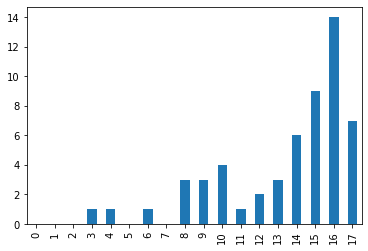

In [36]:
# For week-ends
compute_hist("2112", 9, 20, week_ends).plot.bar()

<AxesSubplot:>

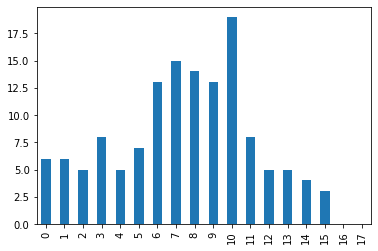

In [37]:
# During the week (no week-ends)
compute_hist("2112", 9, 20, week_days).plot.bar()

<AxesSubplot:>

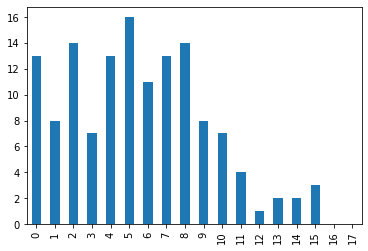

In [38]:
compute_hist("2112", 9, 30, week_days).plot.bar()

<AxesSubplot:>

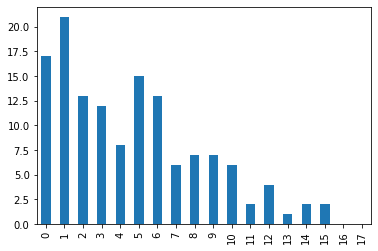

In [39]:
compute_hist("2112", 9, 40, week_days).plot.bar()

<AxesSubplot:>

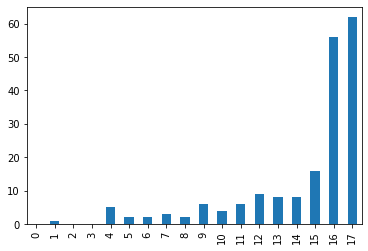

In [40]:
compute_hist("2112", 3, 30).plot.bar()

<AxesSubplot:>

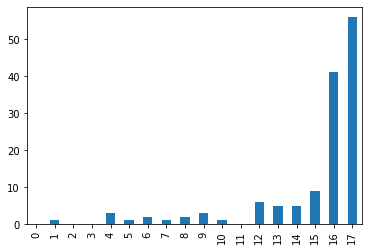

In [41]:
compute_hist("2112", 3, 30, week_days).plot.bar()

<AxesSubplot:>

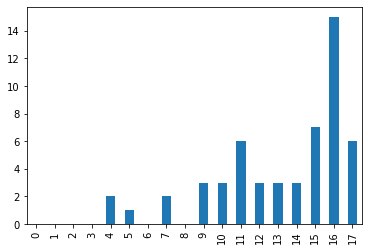

In [42]:
compute_hist("2112", 3, 30, week_ends).plot.bar()

#### Graphs for 2008 (Mairie du 2ème)

<AxesSubplot:>

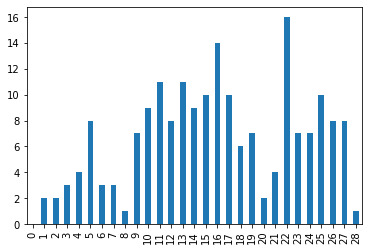

In [43]:
compute_hist("2008", 9, 20).plot.bar()

<AxesSubplot:>

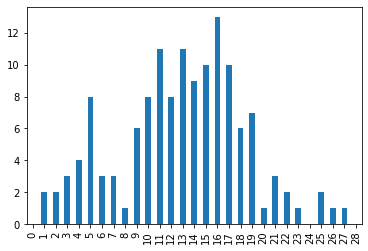

In [44]:
compute_hist("2008", 9, 20, week_days).plot.bar()

<AxesSubplot:>

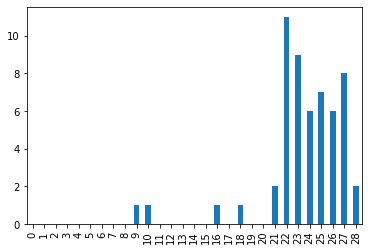

In [45]:
compute_hist("2008", 9, 30, week_ends).plot.bar()

<AxesSubplot:>

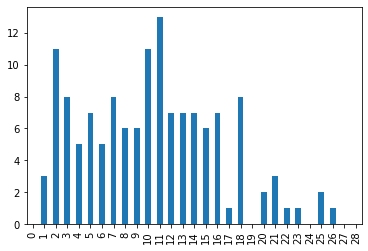

In [46]:
compute_hist("2008", 9, 30, week_days).plot.bar()

<AxesSubplot:>

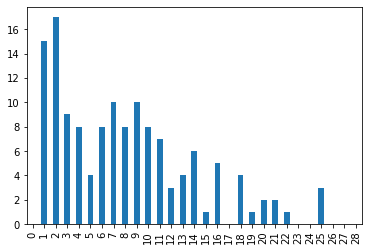

In [47]:
compute_hist("2008", 9, 40, week_days).plot.bar()

<AxesSubplot:>

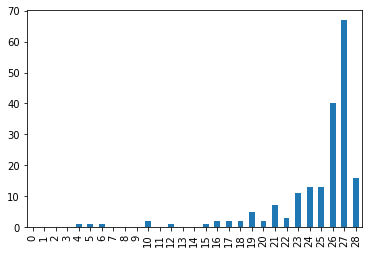

In [48]:
compute_hist("2008", 3, 30).plot.bar()

#### Graphs for 2009 (Filles Saint-Thomas - Place de la Bourse)

<AxesSubplot:>

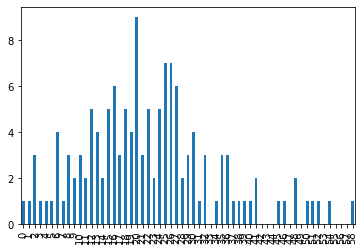

In [49]:
compute_hist("2009", 9, 20, week_days).plot.bar()

<AxesSubplot:>

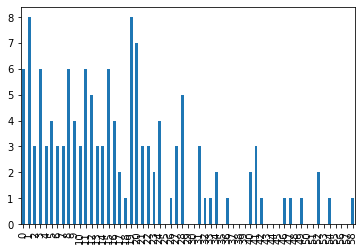

In [50]:
compute_hist("2009", 9, 30, week_days).plot.bar()

<AxesSubplot:>

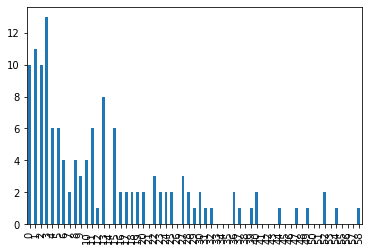

In [51]:
compute_hist("2009", 9, 40, week_days).plot.bar()

<AxesSubplot:>

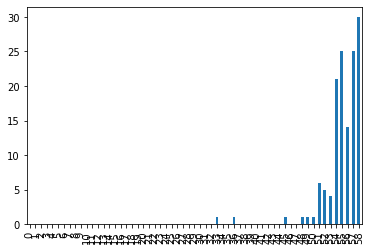

In [52]:
compute_hist("2009", 3, 30, week_days).plot.bar()

#### Comparison across stations

<AxesSubplot:ylabel='Frequency'>

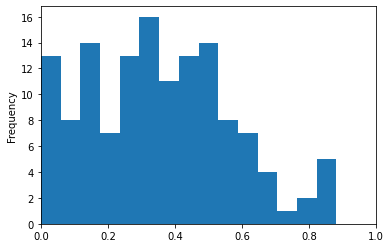

In [53]:
display_hist_ratio("2112", 9, 30, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

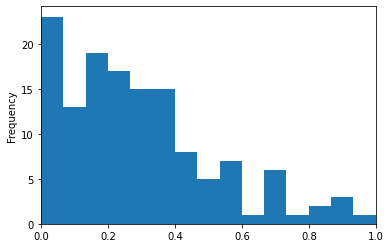

In [54]:
display_hist_ratio("2009", 9, 30, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

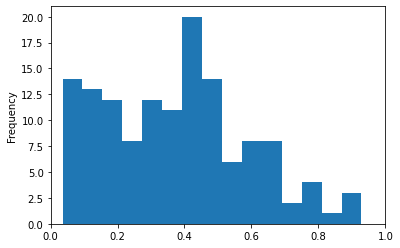

In [55]:
display_hist_ratio("2008", 9, 30, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

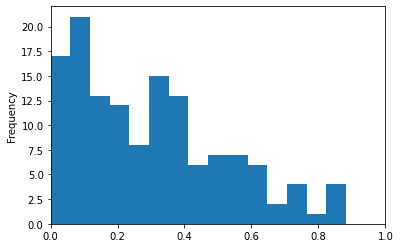

In [56]:
display_hist_ratio("2112", 9, 40, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

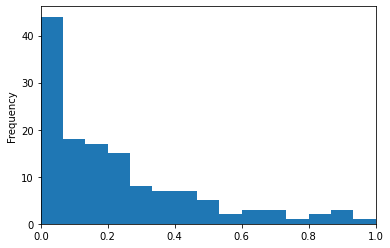

In [57]:
display_hist_ratio("2009", 9, 40, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

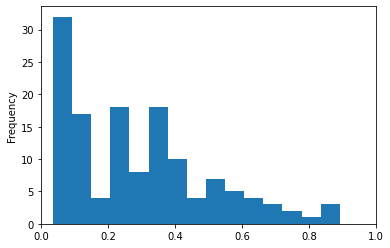

In [58]:
display_hist_ratio("2008", 9, 40, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

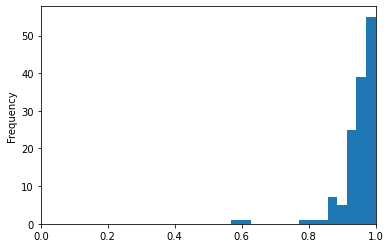

In [59]:
display_hist_ratio("2009", 3, 30, week_days, bins=15)

<AxesSubplot:ylabel='Frequency'>

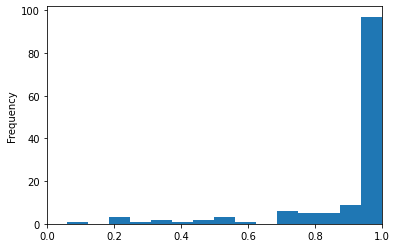

In [60]:
display_hist_ratio("2112", 3, 30, week_days, bins=15)

# About possible features and models

## Basic idea

Possible variables:
* week_days VS week_ends
* vacation (yes/no)
* nbr of bikes available in the different stations close to our starting point

NB: this last condition is only for convenience.

Additional variables would be:
* weather condition (including temperature and rain (yes/no))

And then, remains the question of what kind of model we should use... 

Which variable should we predict?
* As a first step we should predict what is going to happen at 9:30.

## More ideas

Include more data, through a suitable "grouping" of collected data. One idea would be to have a typology of stations and model our stations of interest accordingly.

# Preparation of dataset

In [61]:
aux["month"] = aux.index.month

In [62]:
aux["day"] = aux.index.day

Extract data from 09:00

In [63]:
aux

,stationCode,available_mechanical,available_electrical,capacity,free_docks,free_docks_ratio,local_hour,local_minute,week_day,month,day
file_time,,,,,,,,,,,
2022-05-20 00:00:08+02:00,2112,0.0,1.0,17,16.0,0.941176,0,0,4,5,20
2022-05-20 00:10:08+02:00,2112,0.0,0.0,17,17.0,1.000000,0,10,4,5,20
2022-05-20 00:20:07+02:00,2112,0.0,0.0,17,17.0,1.000000,0,20,4,5,20
2022-05-20 00:30:07+02:00,2112,0.0,0.0,17,17.0,1.000000,0,30,4,5,20
2022-05-20 00:40:07+02:00,2112,0.0,0.0,17,17.0,1.000000,0,40,4,5,20
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18 23:10:08+01:00,2111,8.0,1.0,30,21.0,0.700000,23,10,6,12,18
2022-12-18 23:20:08+01:00,2111,8.0,1.0,30,21.0,0.700000,23,20,6,12,18
2022-12-18 23:30:08+01:00,2111,8.0,1.0,30,21.0,0.700000,23,30,6,12,18


In [64]:
def get_free_docks_ratios(local_hour, local_minute):
    """ Create a table with one column per station and one row per date """
    mask = (aux["local_hour"]==local_hour) & (aux["local_minute"]==local_minute)
    reduced_df = aux[mask].reset_index()[["stationCode", "free_docks_ratio", "month", "day"]]
    
    evol_data = reduced_df.pivot(index=["month", "day"], columns=["stationCode"])
    return evol_data

In [65]:
start_time_data = get_free_docks_ratios(9, 0)
start_time_data

free_docks_ratio                                          \
stationCode             2006      2008      2009      2111      2112   
month day                                                              
5     20            0.958333  0.642857  0.758621  0.733333  0.941176   
      21            0.833333  0.964286  0.913793  0.866667  0.882353   
      22            0.791667  0.928571  0.931034  0.600000  1.000000   
      23            0.583333  0.785714  0.344828  0.766667  0.588235   
      24            0.583333  0.464286  0.534483  0.833333  0.647059   
...                      ...       ...       ...       ...       ...   
12    14            0.666667  0.678571  0.551724  0.600000  0.823529   
      15            0.750000  0.678571  0.741379  0.833333  0.823529   
      16            0.583333  0.964286  0.913793  0.866667  0.941176   
      17            0.791667  0.892857  0.948276  0.900000  0.941176   
      18            0.791667  0.785714  0.913793  0.733333  1.000000   

                                                     
stationCode     21205     21209     21212     21215  
month day                                            
5     20     0.653846  0.366667  0.818182  0.545455  
      21     0.730769  0.200000  0.863636  0.484848  
      22     0.653846  0.400000  0.863636  0.333333  
      23     0.846154  0.633333  0.545455  0.575758  
      24     0.961538  0.900000  0.500000  0.848485  
...               ...       ...       ...       ...  
12    14     0.846154  0.900000  1.000000  0.848485  
      15     0.846154  0.733333  0.818182  0.636364  
      16     0.846154  0.700000  0.772727  0.878788  
      17     0.692308  0.633333  0.590909  0.666667  
      18     0.884615  0.600000  0.818182  0.939394  

[191 rows x 9 columns]

In [66]:
target_time_data = get_free_docks_ratios(9, 30)
target_time_data

free_docks_ratio                                          \
stationCode             2006      2008      2009      2111      2112   
month day                                                              
5     20            0.750000  0.571429  0.586207  0.700000  0.823529   
      21            0.875000  0.964286  0.913793  0.866667  0.764706   
      22            0.791667  0.928571  0.913793  0.600000  1.000000   
      23            0.333333  0.500000  0.086207  0.533333  0.294118   
      24            0.166667  0.250000  0.224138  0.566667  0.411765   
...                      ...       ...       ...       ...       ...   
12    14            0.458333  0.535714  0.362069  0.500000  0.470588   
      15            0.458333  0.500000  0.465517  0.566667  0.470588   
      16            0.375000  0.928571  0.724138  0.800000  0.823529   
      17            0.750000  0.892857  0.931034  0.900000  0.941176   
      18            0.750000  0.785714  0.896552  0.666667  1.000000   

                                                     
stationCode     21205     21209     21212     21215  
month day                                            
5     20     0.500000  0.600000  0.954545  0.545455  
      21     0.769231  0.300000  0.909091  0.484848  
      22     0.615385  0.500000  0.954545  0.363636  
      23     0.692308  0.766667  0.318182  0.303030  
      24     0.884615  0.933333  0.227273  0.696970  
...               ...       ...       ...       ...  
12    14     0.692308  0.900000  0.954545  0.909091  
      15     0.730769  0.866667  0.863636  0.454545  
      16     0.846154  0.800000  0.863636  0.878788  
      17     0.692308  0.666667  0.590909  0.727273  
      18     0.884615  0.633333  0.818182  0.939394  

[191 rows x 9 columns]

In [67]:
output_df = start_time_data.merge(target_time_data, left_index=True, right_index=True, suffixes=["_start", "_target"])
output_df

free_docks_ratio_start                                          \
stationCode                   2006      2008      2009      2111      2112   
month day                                                                    
5     20                  0.958333  0.642857  0.758621  0.733333  0.941176   
      21                  0.833333  0.964286  0.913793  0.866667  0.882353   
      22                  0.791667  0.928571  0.931034  0.600000  1.000000   
      23                  0.583333  0.785714  0.344828  0.766667  0.588235   
      24                  0.583333  0.464286  0.534483  0.833333  0.647059   
...                            ...       ...       ...       ...       ...   
12    14                  0.666667  0.678571  0.551724  0.600000  0.823529   
      15                  0.750000  0.678571  0.741379  0.833333  0.823529   
      16                  0.583333  0.964286  0.913793  0.866667  0.941176   
      17                  0.791667  0.892857  0.948276  0.900000  0.941176   
      18                  0.791667  0.785714  0.913793  0.733333  1.000000   

                                                    free_docks_ratio_target  \
stationCode     21205     21209     21212     21215                    2006   
month day                                                                     
5     20     0.653846  0.366667  0.818182  0.545455                0.750000   
      21     0.730769  0.200000  0.863636  0.484848                0.875000   
      22     0.653846  0.400000  0.863636  0.333333                0.791667   
      23     0.846154  0.633333  0.545455  0.575758                0.333333   
      24     0.961538  0.900000  0.500000  0.848485                0.166667   
...               ...       ...       ...       ...                     ...   
12    14     0.846154  0.900000  1.000000  0.848485                0.458333   
      15     0.846154  0.733333  0.818182  0.636364                0.458333   
      16     0.846154  0.700000  0.772727  0.878788                0.375000   
      17     0.692308  0.633333  0.590909  0.666667                0.750000   
      18     0.884615  0.600000  0.818182  0.939394                0.750000   

                                                                         \
stationCode      2008      2009      2111      2112     21205     21209   
month day                                                                 
5     20     0.571429  0.586207  0.700000  0.823529  0.500000  0.600000   
      21     0.964286  0.913793  0.866667  0.764706  0.769231  0.300000   
      22     0.928571  0.913793  0.600000  1.000000  0.615385  0.500000   
      23     0.500000  0.086207  0.533333  0.294118  0.692308  0.766667   
      24     0.250000  0.224138  0.566667  0.411765  0.884615  0.933333   
...               ...       ...       ...       ...       ...       ...   
12    14     0.535714  0.362069  0.500000  0.470588  0.692308  0.900000   
      15     0.500000  0.465517  0.566667  0.470588  0.730769  0.866667   
      16     0.928571  0.724138  0.800000  0.823529  0.846154  0.800000   
      17     0.892857  0.931034  0.900000  0.941176  0.692308  0.666667   
      18     0.785714  0.896552  0.666667  1.000000  0.884615  0.633333   

                                 
stationCode     21212     21215  
month day                        
5     20     0.954545  0.545455  
      21     0.909091  0.484848  
      22     0.954545  0.363636  
      23     0.318182  0.303030  
      24     0.227273  0.696970  
...               ...       ...  
12    14     0.954545  0.909091  
      15     0.863636  0.454545  
      16     0.863636  0.878788  
      17     0.590909  0.727273  
      18     0.818182  0.939394  

[191 rows x 18 columns]

## Visual investigation of start and target free docks ratios 

In [68]:
def display_start_target_hist(start_station, target_station, gridsize=20):
    
    ax = output_df.plot.hexbin(
        x=( 'free_docks_ratio_start',  start_station), 
        y=('free_docks_ratio_target',  target_station), 
        gridsize=gridsize,
        figsize=(7,6)
    )
    ax.plot((0,1), (0,1), color="red")

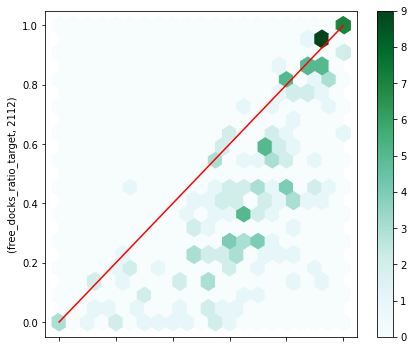

In [69]:
display_start_target_hist("2112", "2112")

From the previous graph, it appears that the starting ratio is always below the final ratio, *i.e.* the station is mostly receiving bikes (instead of losing bikes). For comparison, the station 21209 should be losing bikes:

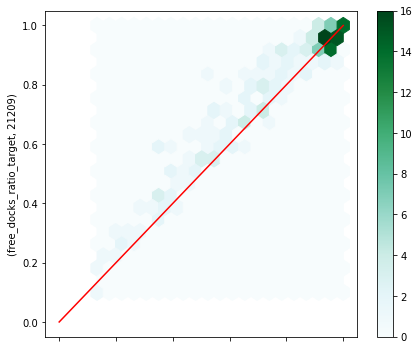

In [70]:
display_start_target_hist("21209", "21209")

It appears to be loosing bike indeed, but fairly slowly!

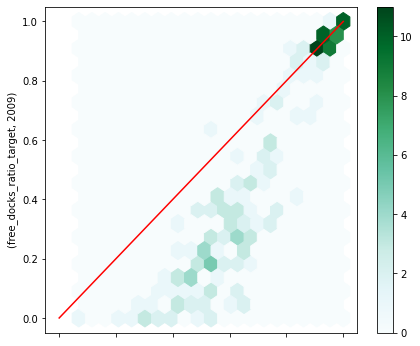

In [71]:
display_start_target_hist("2009", "2009")

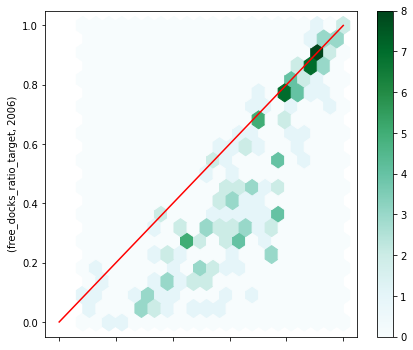

In [72]:
display_start_target_hist("2006", "2006")

## Including date data

Create a table including the characteristics of the date under consideration. 

This is the table where we should input:
* week-day vs week-end
* holiday or not
* temperature
* weather

For the original version, we could start with the simplest characteristics.

In [73]:
import numpy as np

In [74]:
date_data = pd.DataFrame(pd.to_datetime(np.unique(summary_df.index.date)), columns=["date"])

In [75]:
date_data["date"]

0     2022-05-20
1     2022-05-21
2     2022-05-22
3     2022-05-23
4     2022-05-24
         ...    
186   2022-12-14
187   2022-12-15
188   2022-12-16
189   2022-12-17
190   2022-12-18
Name: date, Length: 191, dtype: datetime64[ns]

In [76]:
date_data["week_day"] = date_data["date"].dt.weekday
date_data["month"] = date_data["date"].dt.month
date_data["day"] = date_data["date"].dt.day

In [77]:
date_data["week-end"] = date_data["week_day"].isin(week_ends)

In [78]:
date_data

,date,week_day,month,day,week-end
0,2022-05-20,4,5,20,False
1,2022-05-21,5,5,21,True
2,2022-05-22,6,5,22,True
3,2022-05-23,0,5,23,False
4,2022-05-24,1,5,24,False
...,...,...,...,...,...
186,2022-12-14,2,12,14,False
187,2022-12-15,3,12,15,False
188,2022-12-16,4,12,16,False
189,2022-12-17,5,12,17,True


In [79]:
output_df

free_docks_ratio_start                                          \
stationCode                   2006      2008      2009      2111      2112   
month day                                                                    
5     20                  0.958333  0.642857  0.758621  0.733333  0.941176   
      21                  0.833333  0.964286  0.913793  0.866667  0.882353   
      22                  0.791667  0.928571  0.931034  0.600000  1.000000   
      23                  0.583333  0.785714  0.344828  0.766667  0.588235   
      24                  0.583333  0.464286  0.534483  0.833333  0.647059   
...                            ...       ...       ...       ...       ...   
12    14                  0.666667  0.678571  0.551724  0.600000  0.823529   
      15                  0.750000  0.678571  0.741379  0.833333  0.823529   
      16                  0.583333  0.964286  0.913793  0.866667  0.941176   
      17                  0.791667  0.892857  0.948276  0.900000  0.941176   
      18                  0.791667  0.785714  0.913793  0.733333  1.000000   

                                                    free_docks_ratio_target  \
stationCode     21205     21209     21212     21215                    2006   
month day                                                                     
5     20     0.653846  0.366667  0.818182  0.545455                0.750000   
      21     0.730769  0.200000  0.863636  0.484848                0.875000   
      22     0.653846  0.400000  0.863636  0.333333                0.791667   
      23     0.846154  0.633333  0.545455  0.575758                0.333333   
      24     0.961538  0.900000  0.500000  0.848485                0.166667   
...               ...       ...       ...       ...                     ...   
12    14     0.846154  0.900000  1.000000  0.848485                0.458333   
      15     0.846154  0.733333  0.818182  0.636364                0.458333   
      16     0.846154  0.700000  0.772727  0.878788                0.375000   
      17     0.692308  0.633333  0.590909  0.666667                0.750000   
      18     0.884615  0.600000  0.818182  0.939394                0.750000   

                                                                         \
stationCode      2008      2009      2111      2112     21205     21209   
month day                                                                 
5     20     0.571429  0.586207  0.700000  0.823529  0.500000  0.600000   
      21     0.964286  0.913793  0.866667  0.764706  0.769231  0.300000   
      22     0.928571  0.913793  0.600000  1.000000  0.615385  0.500000   
      23     0.500000  0.086207  0.533333  0.294118  0.692308  0.766667   
      24     0.250000  0.224138  0.566667  0.411765  0.884615  0.933333   
...               ...       ...       ...       ...       ...       ...   
12    14     0.535714  0.362069  0.500000  0.470588  0.692308  0.900000   
      15     0.500000  0.465517  0.566667  0.470588  0.730769  0.866667   
      16     0.928571  0.724138  0.800000  0.823529  0.846154  0.800000   
      17     0.892857  0.931034  0.900000  0.941176  0.692308  0.666667   
      18     0.785714  0.896552  0.666667  1.000000  0.884615  0.633333   

                                 
stationCode     21212     21215  
month day                        
5     20     0.954545  0.545455  
      21     0.909091  0.484848  
      22     0.954545  0.363636  
      23     0.318182  0.303030  
      24     0.227273  0.696970  
...               ...       ...  
12    14     0.954545  0.909091  
      15     0.863636  0.454545  
      16     0.863636  0.878788  
      17     0.590909  0.727273  
      18     0.818182  0.939394  

[191 rows x 18 columns]